In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerNN, KerasRNN
from sklearn import metrics

Using TensorFlow backend.


Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


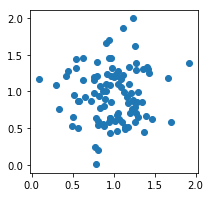

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

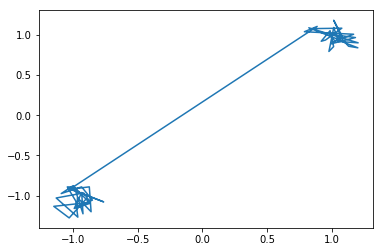

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
# SEM parameters
K = 20  # maximum number of event types
lmda = 10  # stickyness parameter
alfa = 1.00  # concentration parameter
beta = 0.1 # transition noise
eta =  0.1  # learning rate


# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
        
    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print 
    print np.argmax(post, axis=1)

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 0.777511795806
Adjusted Rand Score: 0.882313696711

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


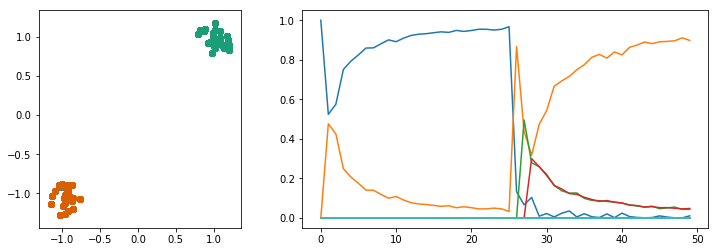

In [6]:
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.45733025684
Adjusted Rand Score: 0.704245188116

[0 1 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 4 5 6 7 5 8 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5]


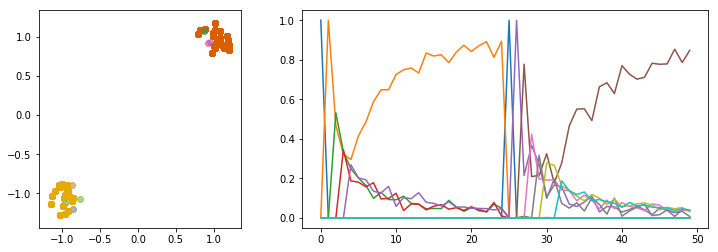

In [7]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasLDS, f_opts=dict())

sem2 = SEM(**sem_kwargs)
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.261053201018
Adjusted Rand Score: 0.45504179024

[ 0  1  2  3  2  2  4  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  0  5  6  7  8  6  6  6  9 10 11 12 13 10 10 10 14 10 10 15 10 10 10 10 10]


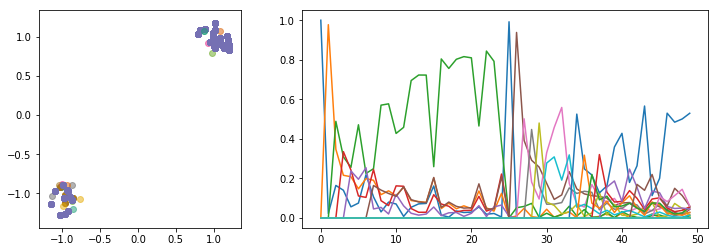

In [8]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasMultiLayerNN, f_opts=dict())

sem3 = SEM(**sem_kwargs)
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 0.480109133494
Adjusted Rand Score: 0.707531352693

[0 1 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 5 6 7 6 7 7 8 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7]


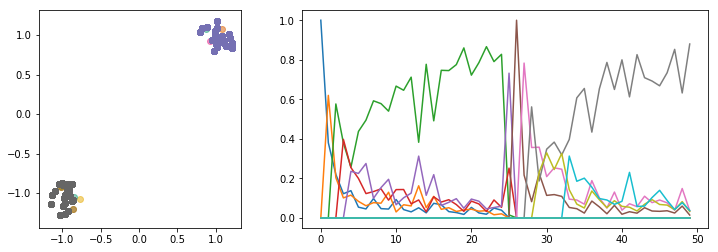

In [9]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasRNN, f_opts=dict(t=5))

sem4 = SEM(**sem_kwargs)
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)

# Alternating between 2 static events


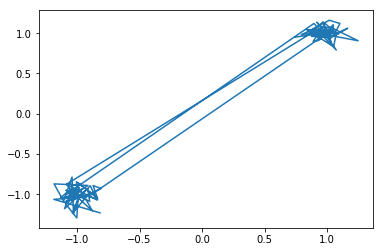

In [10]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 0.223801367422
Adjusted Rand Score: 0.205475599467

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


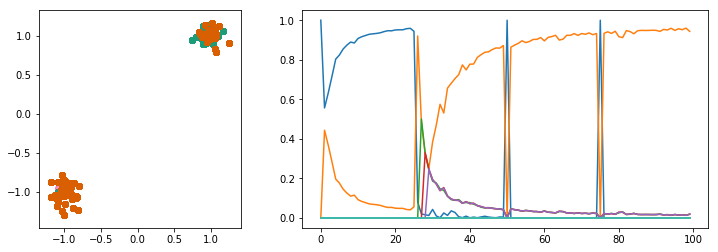

In [11]:
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.634993263717
Adjusted Rand Score: 0.827288661184

[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 5 6 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5]


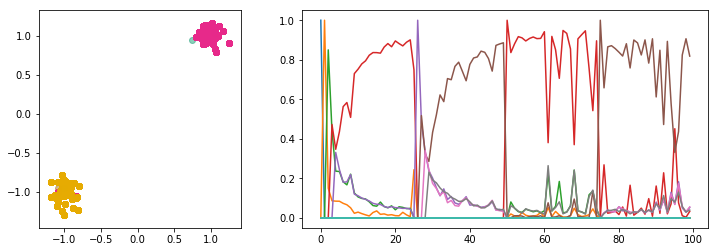

In [12]:
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.308740221472
Adjusted Rand Score: 0.50823847905

[ 0  1  2  3  4  5  6  7  1  1  1  1  1  1  1  1  1  6  5  5  8  9  1  1  1
  5 10 11 12 13 12 12 12 10 14 15 14 16 17 18 19 19 19 19 19 19 19 19 19 19
  6  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19]


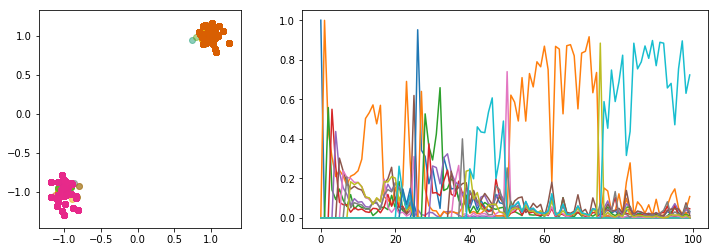

In [13]:
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 0.329670981422
Adjusted Rand Score: 0.604188172836

[ 0  1  2  2  3  4  5  6  2  7  2  2  2  2  2  2  8  9 10 11 12 13 14 15  3
  0 16 17 18 19 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 17  2
 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17]


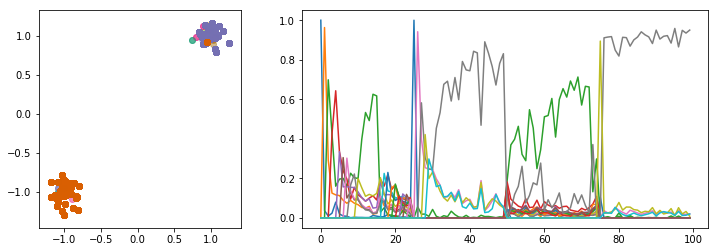

In [14]:
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)

# Example of four events where the events correspond to movement in vector space

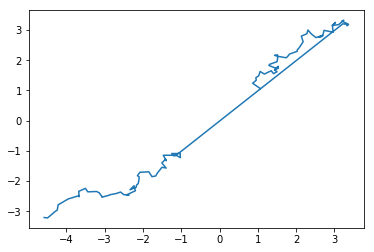

In [15]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

models/sem.py:124: RuntimeWarning: divide by zero encountered in log
  lik[k] = np.log(mvnormal.pdf(X_curr - Y_hat, mean=np.zeros(D), cov=Sigma))



Adjusted Mutual Information: 0.157271636353
Adjusted Rand Score: 0.25463124423

[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  2  2  2  0  2  2  2  2  2  3  2  4  5  1  1  6  7  8
  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  1  1  2  7  7  7  7  7  7  9  9  9  9  9  7 10 11 10  4 12 13 10 14 15]


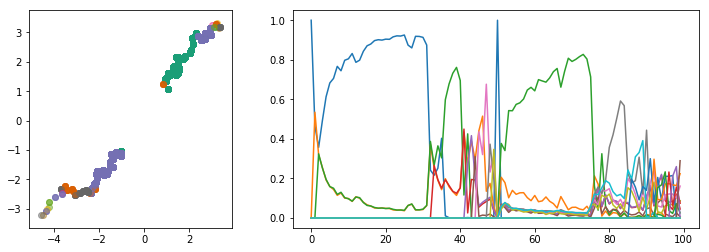

In [16]:
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: -0.0166739576076
Adjusted Rand Score: -0.00120042096955

[ 0  1  2  3  2  2  4  2  2  2  5  6  3  7  7  7  8  9  2 10 11 12 13  2 14
  3 15 16  3 17 18 19  8  4  4  4 14 14 10  9  9  9  9  9  9  9  9  9  9  9
  0  3  2  2  3  2  2  2  2  2  2  2  2  2  2  2  4 10 15  7  7 14 14  5 13
  6 18  7 14 14 14  9  9  9  9  9  9  9  9  9 13  5  9  9  9  9  9  9  9  9]


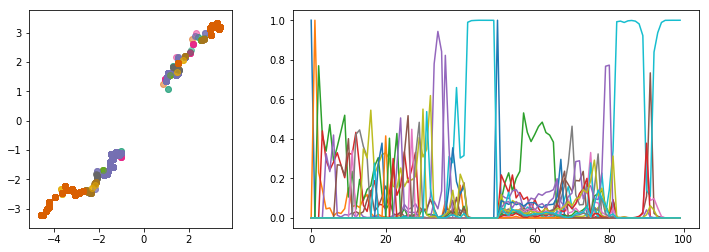

In [17]:
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.236159722015
Adjusted Rand Score: 0.442407958158

[ 0  0  1  2  3  4  5  6  7  8  9 10  8  8  8  8  8 11 12 13 14 15 16 17 18
 19 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
  4 17  1 14 14 14 14 14 14 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18]


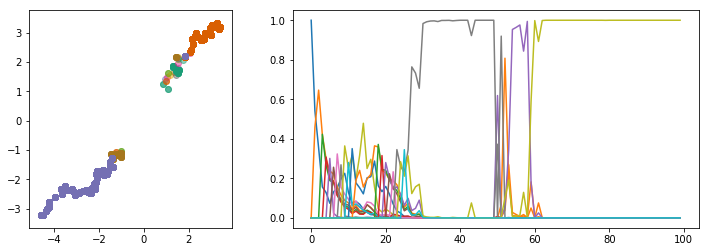

In [18]:
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 0.0916170394014
Adjusted Rand Score: 0.0402678516577

[ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  6  7  8  9 10
  0 11 12  4  4 13 13 13  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4 14 15 16 17 18 19 17 17 17 15 19 17 17 17 17 15 17 17]


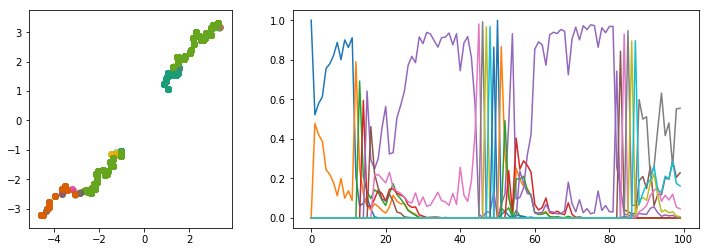

In [19]:
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)

# 4 events where the events correspond to movement in vector space


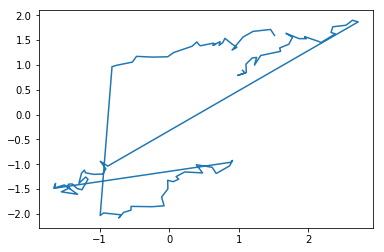

In [20]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 0.337659932958
Adjusted Rand Score: 0.300819890759

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


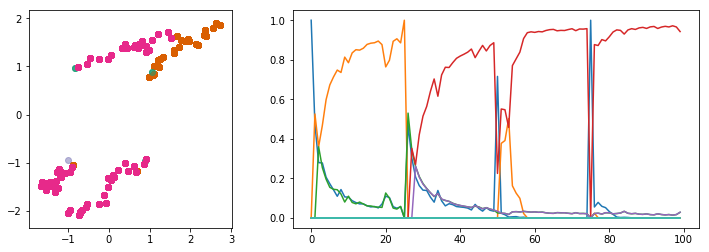

In [21]:
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.377664006375
Adjusted Rand Score: 0.454765262946

[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  3  4  5
  0  3  6  7  3  3  3  8  9  7  7  7  7  7  7 10 11 12  7  7  7  7  7  7  7
  0 13 14 14 14 14 14  0 15 16 17 18 19 16 16 16 16 16 16 16 16 16 16  7  7
  1 17 17 17 17 17 16 12 12 12 12 12 12 12 12 12 12 12 12 12 16 12 12 12  3]


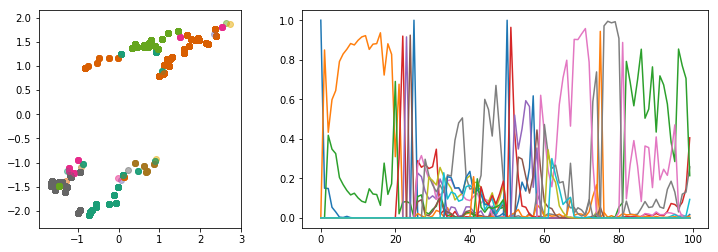

In [22]:
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.280601808394
Adjusted Rand Score: 0.33115978376

[ 0  1  2  3  4  5  6  7  8  5  9 10 11 11 12 13 14 15 16 17 18 19 16 19 19
  2 10 15 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  0  2  5  2  2  2  2  2  2  2  2  2  2  2  2  2 10 10 10 10 10 10 10 10 10
  1 10 10  1  1  1  1  1  1  1  8  4  8  8  8  8  8  8  8  8  8  8 11 11 11]


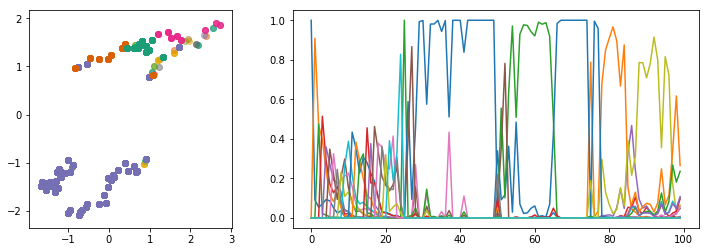

In [23]:
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 0.395367711863
Adjusted Rand Score: 0.427926560959

[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4  5  6  5  7  3  5  3  3
  0  8  9 10  9  9 11 12  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  2 13 14 15 16 17 18 19 19 19 19 19 19 19 19 19 19 19 19 19  9  9  9  9  9
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  0  0  0  0  0  0  0  0]


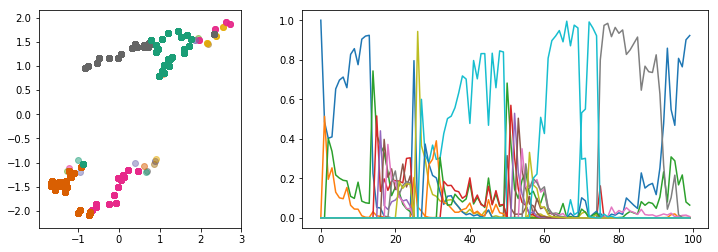

In [24]:
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)

# 

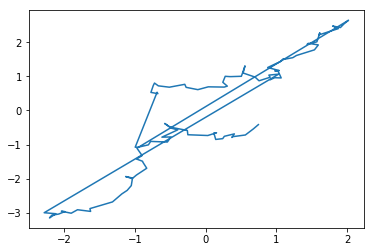

In [25]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 0.0234218884387
Adjusted Rand Score: 0.00994108637846

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 3 4 5 2 2 6 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


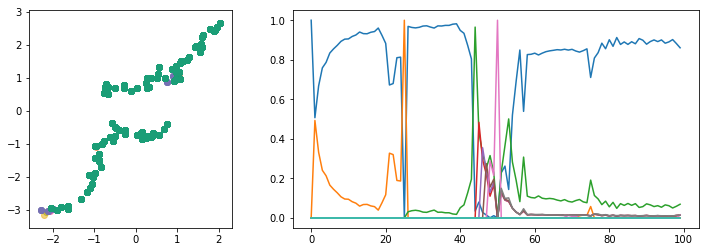

In [26]:
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.050230480622
Adjusted Rand Score: 0.0354758265626

[ 0  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  3  1  1  4  1  1  5  6  7
  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  8  9 10 11 12 10 13 14 14 15
  0  1  1  1  1  1  1 14 14 14 14 14 14  1  1  1  1 16 17 18 19 15  8 15 18
  0  6  1  1  1  1  1  1  1  1  1  1  1  1  7  1  1  1  1  1  1  1  1  1  1]


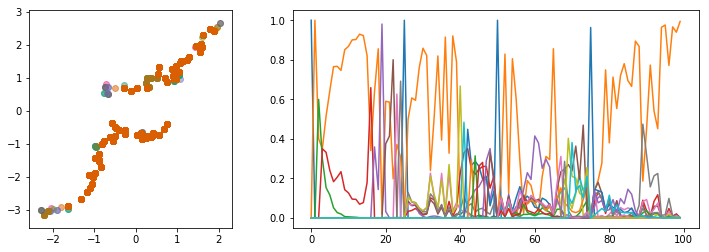

In [ ]:
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

In [ ]:
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

In [ ]:
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)